In [1]:
using StatsPlots
using LinearAlgebra
using Random
using Statistics
using Distributions
using Plots
using LaTeXStrings

In [2]:
function MHRW(energia,np,p0,δ=0.5,iterations=10000)
    
    
    #Muestras del algorimo
    samples = zeros(np,iterations)
    #Punto de partida
    ## Se escoge el punto inicial obtenido de invertir el operador A
    samples[:,1] = p0
    
    #Probabilidades
    probabilities = zeros(iterations)
    probabilities[1] = energia(samples[:,1])
    
    #Tasa de aceptación
    rateAlpha = 0
    
    # Algoritmo Metrópolis-Hastings
    for i in 1:iterations-1
        
        #Estado actual
        Xᵢ = samples[:,i]
        #Estado propuesto
        X₊ = rand(MvNormal(Xᵢ,δ*I))
        
        #π(Estado actual → Estado propuesto)
        pXᵢX₊ = energia(X₊) * pdf(MvNormal(Xᵢ,δ*I),X₊)
        #π(Estado propuesto → Estado actual)
        pX₊Xᵢ = energia(Xᵢ) * pdf(MvNormal(X₊,δ*I),Xᵢ)
        #Tasa de aceptacion α
        alpha = min(1, pXᵢX₊/pX₊Xᵢ)
    
        #Aceptación o rechazo del estado propuesto
        u = rand()    
        if u < alpha 				#Aceptación
            samples[:,i+1] = X₊
            probabilities[i+1] = energia(X₊)
            rateAlpha += 1
        else 						#Rechazo
            samples[:,i+1] = Xᵢ
            probabilities[i+1] = energia(Xᵢ)
        end
    end
    rateAlpha /= (iterations-1)
    MAP = samples[:,findmax(probabilities)[2]]
    CM = [mean(row) for row in eachrow(samples)]
    return samples, probabilities, MAP, CM, rateAlpha
end

MHRW (generic function with 3 methods)

In [3]:
function MCIntegration(s)
    n = length(s)
    integral = zeros(n)
    convergence = zeros(n-1)
    for i in 1:n
        integral[i] = mean(s[1:i])
    end
    for j in 2:n
        convergence[j-1] = abs(integral[j]-integral[j-1])
    end
    A = [ones(n-1) log.(1:n-1) ]
    #rate = (A' * A + 0.001*I) \ (A' * log.(convergence .+ 0.001))
    rate = A \ log.(convergence .+ 1E-8)
    return convergence, rate
end

MCIntegration (generic function with 1 method)

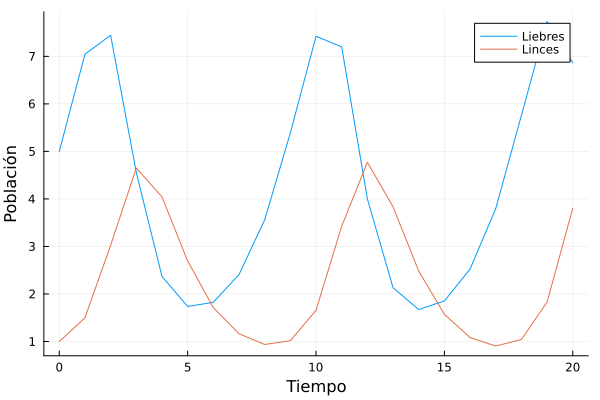

In [4]:
function lotka_volterra(du, u, p, t)
    x, y = u  # x: liebres, y: linces
    α, β, γ, δ = p  # Parámetros del modelo
    du[1] = α * x - β * x * y
    du[2] = -γ * y + δ * x * y
end

function solve_euler(f, u0, tspan, p, dt=0.01)
    t_start, t_end = tspan
    t = t_start
    u = copy(u0)
    
    t_values = Float64[]
    u_values = Vector{Float64}[]

    push!(t_values, t)
    push!(u_values, copy(u))

    du = zeros(eltype(u0), length(u0)) 

    while t < t_end
        f(du, u, p, t)   

        @. u += du * dt  
        t += dt

        push!(t_values, t)
        push!(u_values, copy(u))
    end
    t_values = t_values[1:100:end]
    u_values = hcat(u_values...)'[1:100:end,:]
    
    return t_values, u_values
end

t_values, u_values = solve_euler(lotka_volterra, [5.0, 1.0], (0.0, 20.0), [0.7, 0.3, 0.8, 0.2])

plot(t_values, u_values[:, 1], label="Liebres", xlabel="Tiempo", ylabel="Población", legend=:topright)
plot!(t_values, u_values[:, 2], label="Linces")



In [5]:
u_values

21×2 Matrix{Float64}:
 5.0      1.0
 7.04479  1.4985
 7.4431   3.02377
 4.55795  4.64923
 2.36998  4.04549
 1.73751  2.69449
 1.8257   1.71208
 2.40793  1.16344
 3.55938  0.937958
 5.38911  1.01812
 7.42244  1.65692
 7.1983   3.42634
 4.00044  4.77046
 2.13133  3.83299
 1.67298  2.482
 1.85368  1.57193
 2.52568  1.08349
 3.79698  0.9045
 5.76134  1.04382
 7.73194  1.83124
 6.86468  3.80623

In [6]:
Dinamic = zeros(21,3)
for i in 1:21
    Dinamic[i,1] = 1910 + 2*(i-1)
    Dinamic[i,2], Dinamic[i,3] = u_values[i,:]
end
Dinamic[:,2:3] = Dinamic[:,2:3] .* rand(Gamma(200,1/200),(21,2))

21×2 Matrix{Float64}:
 5.18963  1.04939
 6.25339  1.60623
 7.51986  3.2809
 4.62676  4.73145
 2.24765  3.36921
 1.7498   2.57554
 1.71991  1.74533
 2.22439  1.15833
 3.64278  0.940624
 5.26066  0.877865
 7.00171  1.68619
 6.9755   3.32513
 4.3543   4.96107
 2.17073  4.36014
 1.62896  2.54618
 1.797    1.76254
 2.42131  1.00618
 4.16212  0.826099
 5.87604  1.12227
 7.95093  1.75168
 6.62071  3.93399

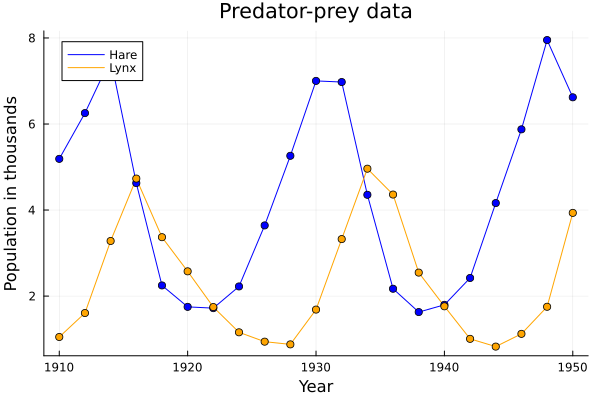

In [7]:
plot(Dinamic[:,1],Dinamic[:,2],label="Hare",title="Predator-prey data",color=:blue)
plot!(Dinamic[:,1],Dinamic[:,3],label="Lynx",color=:orange,xlabel="Year",ylabel="Population in thousands")
scatter!(Dinamic[:,1],Dinamic[:,2],label="",color=:blue)
scatter!(Dinamic[:,1],Dinamic[:,3],label="",color=:orange)

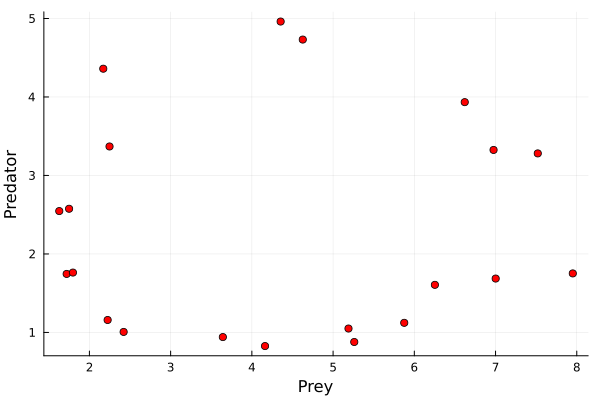

In [8]:
scatter(Dinamic[:,2],Dinamic[:,3],label="",xlabel="Prey",ylabel="Predator",color=:red)

In [9]:
function energy(p)
    α, β, γ, δ = p    
    t, λ = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), p)
    
    #Likelihood 
    likelihood = exp( mean(logpdf.(Normal.(λ,0.1), Dinamic[:,2:3] )) )

    #Prior
    prior = 1.0
    prior *= pdf(Uniform(0.0,1.0),α)
    prior *= pdf(Uniform(0.0,1.0),β)
    prior *= pdf(Uniform(0.0,1.0),γ)
    prior *= pdf(Uniform(0.0,1.0),δ)
    
    return likelihood*prior*1E1
end

energy (generic function with 1 method)

In [10]:
energy([0.7, 0.3, 0.8, 0.2])

0.4926262047854083

In [21]:
iterations = 10000

#Muestras del algorimo
samples = zeros(4,iterations)
#Punto de partida
## Se escoge el punto inicial
samples[:,1] = [0.5,0.5,0.5,0.5]#rand(Uniform(0,1),4)

step = 0.005

#Probabilidades
probabilities = zeros(iterations)
probabilities[1] = energy(samples[:,1])

#Tasa de aceptación
rateAlpha = 0

# Algoritmo Metrópolis-Hastings
for i in 1:iterations-1
    
    #Estado actual
    Xᵢ = samples[:,i]
    #Estado propuesto
    X₊ = rand(MvNormal(Xᵢ,step*I))
    
    #π(Estado actual → Estado propuesto)
    pXᵢX₊ = energy(X₊) * pdf(MvNormal(Xᵢ,step*I),X₊)
    #π(Estado propuesto → Estado actual)
    pX₊Xᵢ = energy(Xᵢ) * pdf(MvNormal(X₊,step*I),Xᵢ)
    #Tasa de aceptacion α
    if pX₊Xᵢ>0
        alpha = min(1, pXᵢX₊/pX₊Xᵢ)
    else
        alpha = 0.0
    end
    #Aceptación o rechazo del estado propuesto
    u = rand()    
    if u < alpha 				#Aceptación
        samples[:,i+1] = X₊
        probabilities[i+1] = energy(X₊)
        rateAlpha += 1
    else 						#Rechazo
        samples[:,i+1] = Xᵢ
        probabilities[i+1] = energy(Xᵢ)
    end
end
rateAlpha /= (iterations-1)
@show rateAlpha 
@show MAP = samples[:,findmax(probabilities)[2]]
@show CM = [mean(row) for row in eachrow(samples)]


rateAlpha = 0.0038003800380038005
MAP = samples[:, (findmax(probabilities))[2]] = [0.6420455493543942, 0.26576956400165713, 0.8616444789275979, 0.2079083672029225]
CM = [mean(row) for row = eachrow(samples)] = [0.6625412064749719, 0.28408505117539334, 0.8354326456206088, 0.20606906456791302]


4-element Vector{Float64}:
 0.6625412064749719
 0.28408505117539334
 0.8354326456206088
 0.20606906456791302

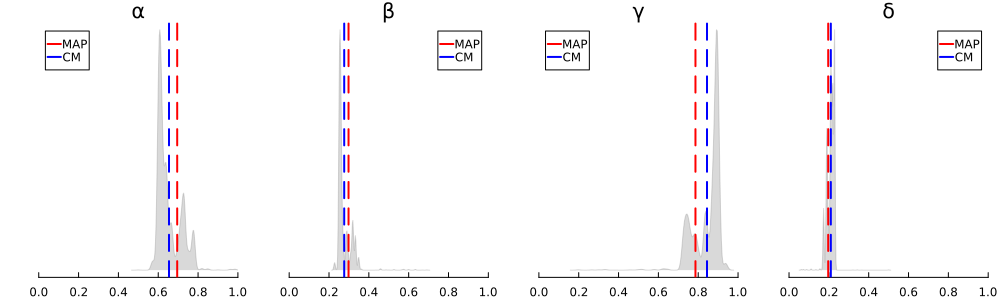

In [13]:
p1 = density(samples[1,:],label="",title="α",fill=true,alpha=0.3,color=:gray,
    xlim=(0,1),yaxis=false,legend=:topleft,grid=false)
p1 = vline!([MAP[1]], label="MAP", linestyle=:dash, color=:red,lw=2)
p1 = vline!([CM[1]], label="CM", linestyle=:dash, color=:blue,lw=2)

p2 = density(samples[2,:],label="",title="β",fill=true,alpha=0.3,color=:gray,
    xlim=(0,1),yaxis=false,legend=:topright,grid=false)
p2 = vline!([MAP[2]], label="MAP", linestyle=:dash, color=:red,lw=2)
p2 = vline!([CM[2]], label="CM", linestyle=:dash, color=:blue,lw=2)

p3 = density(samples[3,:],label="",title="γ",fill=true,alpha=0.3,color=:gray,
    xlim=(0,1),yaxis=false,legend=:topleft,grid=false)
p3 = vline!([MAP[3]], label="MAP", linestyle=:dash, color=:red,lw=2)
p3 = vline!([CM[3]], label="CM", linestyle=:dash, color=:blue,lw=2)

p4 = density(samples[4,:],label="",title="δ",fill=true,alpha=0.3,color=:gray,
    xlim=(0,1),yaxis=false,legend=:topright,grid=false)
p4 = vline!([MAP[4]], label="MAP", linestyle=:dash, color=:red,lw=2)
p4 = vline!([CM[4]], label="CM", linestyle=:dash, color=:blue,lw=2)


plot(p1,p2,p3,p4,layout=(1,4),size=(1000,300))
#savefig("5_LoktaVolterraHistograms.png")

In [14]:
samples

4×10000 Matrix{Float64}:
 0.5  0.5  0.5  0.589672  0.653298  0.653298  …  0.617518  0.617518  0.617518
 0.5  0.5  0.5  0.468841  0.528777  0.528777     0.250837  0.250837  0.250837
 0.5  0.5  0.5  0.380233  0.340969  0.340969     0.891629  0.891629  0.891629
 0.5  0.5  0.5  0.365054  0.342624  0.342624     0.218824  0.218824  0.218824

In [15]:
tMAP, uMAP = solve_euler(lotka_volterra, [5.0, 1.0], (0.0, 20.0), MAP)

([0.0, 1.0000000000000007, 2.0000000000000013, 2.99999999999998, 3.9999999999999587, 4.999999999999938, 5.9999999999999165, 6.999999999999895, 7.999999999999874, 8.999999999999853  …  10.99999999999981, 11.999999999999789, 12.999999999999767, 13.999999999999746, 14.999999999999725, 15.999999999999703, 16.999999999999858, 18.000000000000014, 19.00000000000017, 20.000000000000327], [5.0 1.0; 7.035236520117065 1.4875661839428644; … ; 7.3998978910573605 1.5531508714038351; 7.499950801751355 3.255459210581078])

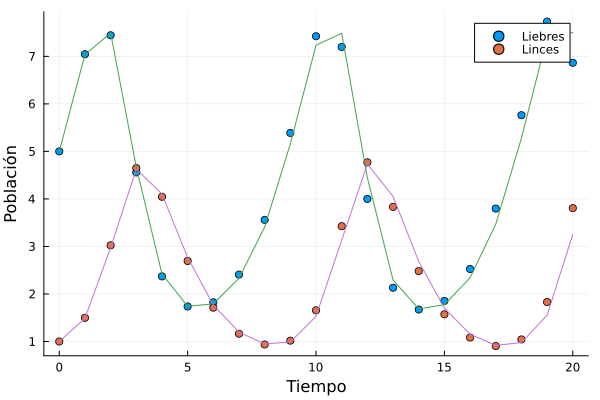

In [16]:
scatter(t_values, u_values[:, 1], label="Liebres", xlabel="Tiempo", ylabel="Población", legend=:topright)
scatter!(t_values, u_values[:, 2], label="Linces")
plot!(tMAP, uMAP[:, 1], label="", xlabel="Tiempo", ylabel="Población", legend=:topright)
plot!(tMAP, uMAP[:, 2], label="")


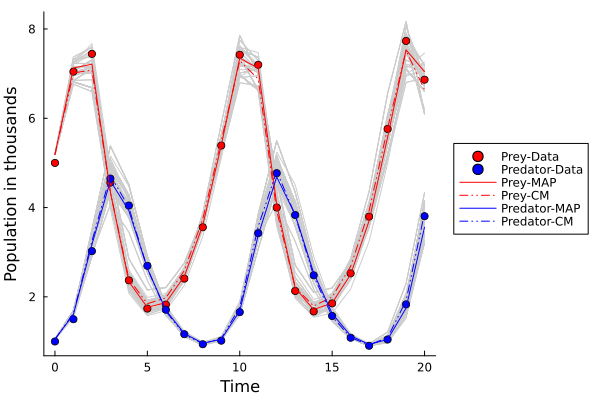

In [17]:
ts, us = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), samples[:,1000])

plotsample = plot(ts, us[:, 1], label="",color=:gray80,grid=false,
                xlabel="Time", ylabel="Population in thousands",legend=:outerright)
plotsample = plot!(ts, us[:, 2], label="",color=:gray80)


for k in 1000:100:10000
    ts, us = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), samples[:,k])
    plotsample = plot!(ts, us[:, 1], label="",color=:gray80)
    plotsample= plot!(ts, us[:, 2], label="",color=:gray80)
end

plotsample = scatter!(t_values, u_values[:, 1], label="Prey-Data",color=:red)
plotsample = scatter!(t_values, u_values[:, 2], label="Predator-Data",color=:blue)


tMAP, uMAP = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), MAP)
tCM, uCM = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), CM)


plotsample = plot!(tMAP, uMAP[:, 1], label="Prey-MAP",color=:red,linestyle=:solid)
plotsample = plot!(tCM, uCM[:, 1], label="Prey-CM",color=:red,linestyle=:dashdotdot)
plotsample = plot!(tMAP, uMAP[:, 2], label="Predator-MAP",color=:blue,linestyle=:solid)
plotsample = plot!(tCM, uCM[:, 2], label="Predator-CM",color=:blue,linestyle=:dashdotdot)

#savefig("5_LoktaVolterraDynamics_a.png")

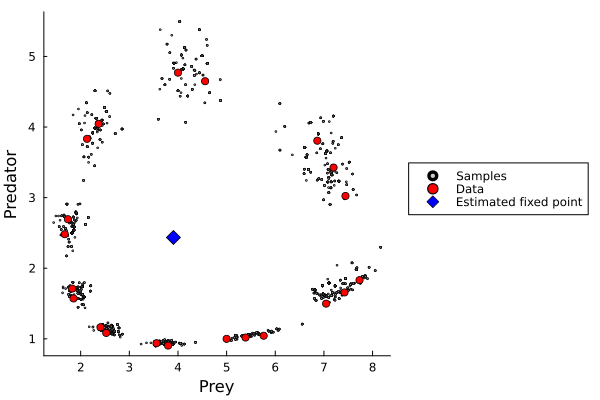

In [18]:
ts, us = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), samples[:,1000])

phasesample = scatter(us[:,1],us[:,2],label="Samples",xlabel="Prey",ylabel="Predator",
                    color=:gray80,linestyle=:dot,markersize=0.99,grid=false,legend=:outerright)


for k in 1000:50:10000
    tsk, usk = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), samples[:,k])
    phasesample = scatter!(usk[:,1],usk[:,2],label="",color=:gray80,linestyle=:dot,markersize=0.99)
end

phasesample = scatter!(u_values[:,1],u_values[:,2],label="Data",color=:red)


phasesample = scatter!([3.90621],[2.43556],label="Estimated fixed point", color=:blue,markersize=7, marker=:diamond)

#savefig("5_LoktaVolterraDynamics_b.png")

In [19]:
fixed = zeros(2,10000)
fixed[1,:]  = samples[1,:] ./ samples[2,:]
fixed[2,:]  = samples[3,:] ./ samples[4,:]
fixed

2×10000 Matrix{Float64}:
 1.0  1.0  1.0  1.25772  1.23549   …  2.46183  2.46183  2.46183  2.46183
 1.0  1.0  1.0  1.04158  0.995169     4.07465  4.07465  4.07465  4.07465

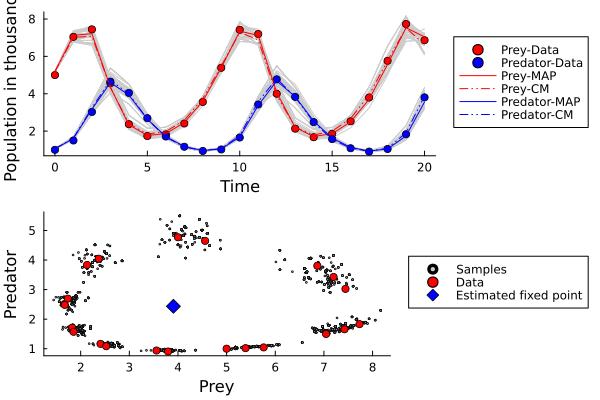

In [20]:
plot(plotsample,phasesample,layout=(2,1))
#savefig("5_LoktaVolterraDynamics.png")